In [20]:
import os
import numpy as np
from scipy import misc
import argparse
import json
import cv2

from tensorpack import *
from bone_point import Model
from reader import Data
from cfgs.config import cfg


from matplotlib import pyplot as plt
%matplotlib inline

In [85]:
img_name = "096699ef-7628-4b94-b5a3-44a01a28a225.png"

In [75]:
# initialize the model
depth = 18
model = Model(depth)
sess_init = SaverRestore("train_log/bone_point0531-131210/model-2500")
predict_config = PredictConfig(session_init=sess_init,
                               model=model,
                               input_names=["input"],
                               output_names=["logits"])

In [76]:
predict_func = OfflinePredictor(predict_config)

[0531 14:35:25 @sessinit.py:127] WRN Variable global_step:0 in checkpoint not found in the graph!
[0531 14:35:25 @sessinit.py:127] WRN Variable input_queue_size/EMA:0 in checkpoint not found in the graph!
[0531 14:35:25 @sessinit.py:127] WRN Variable learning_rate:0 in checkpoint not found in the graph!
[0531 14:35:25 @sessinit.py:127] WRN Variable tower0/l2_regularize_loss/EMA:0 in checkpoint not found in the graph!
[0531 14:35:25 @sessinit.py:127] WRN Variable tower0/loss/EMA:0 in checkpoint not found in the graph!
[0531 14:35:25 @sessinit.py:99] Restoring checkpoint from train_log/bone_point0531-131210/model-2500 ...
INFO:tensorflow:Restoring parameters from train_log/bone_point0531-131210/model-2500


In [86]:
img_path = "doodles/" + cfg.name + "/" + img_name
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
input_img = np.expand_dims(img, axis=0)

In [87]:
predictions = predict_func([input_img])[0][0]
norm_bones = predictions + np.asarray(cfg.anchor_bones)

In [88]:
# restore bboxes from mask images
bboxes = []
for label_idx in range(cfg.obj_num):
    mask_path = img_path.replace("png", "mask." + str(label_idx) + ".png")
    cur_label_img = misc.imread(mask_path, mode='L')
    cur_label_img = np.minimum(cur_label_img, np.ones(cur_label_img.shape))

    t = np.nonzero(cur_label_img)
    ymin = np.min(t[0])
    ymax = np.max(t[0])
    xmin = np.min(t[1])
    xmax = np.max(t[1])
    bboxes.append([xmin, ymin, xmax, ymax])

In [89]:
print(norm_bones)

[ 0.46593067  0.28489727  0.18842042  0.31190765 -0.04534023  0.27405907
 -0.16089714  0.12227658 -0.15632337 -0.04428906 -0.10869864 -0.21445544
 -0.16420277 -0.43618428 -0.01587017 -0.04195086  0.14877034  0.33266393
 -0.84406621  0.14071708  0.11481688  0.08931833 -0.50778358 -0.32374651
 -0.03856109  0.25145144]


In [90]:
# restore abolute coords for bones
bones = []
i = 0
for box_idx in cfg.match:
    norm_bone = norm_bones[i:i+2]
    i += 2
    [xmin, ymin, xmax, ymax] = bboxes[box_idx]
    xcenter = (xmax + xmin) / 2
    ycenter = (ymax + ymin) / 2
    box_width = (xmax - xmin)
    box_height = (ymax - ymin)
    x = norm_bone[0] * box_width + xcenter
    y = norm_bone[1] * box_height + ycenter
    bones.append([int(x), int(y)])

In [92]:
for bone in bones:
    img = cv2.circle(img, (bone[0], bone[1]), 2, (255, 255, 255), thickness=2, lineType=8, shift=0)

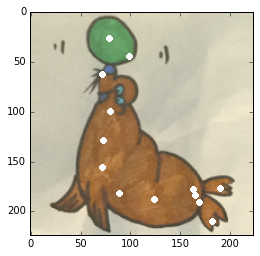

In [93]:
plt.imshow(img)